# Mobile apps reviews classification with spaCy and sklearn

This notebook illustrates text classification using **Bag od Words (BoW)** and **Vector Space Model (VSM)** for text representation and **Naive Bayes (NB)** algorithm for classification. <br>

The classification task is classification of mobile app reviews into:
* functional requirements,
* non-functional requirements,
* other (reviews irrelevant from Requirements Engineering perspective)

The dataset used in the notebook originates from the paper [Listening to the Crowd for the Release Planning of Mobile Apps](https://ieeexplore.ieee.org/abstract/document/8057860) and can be downloaded from [here](https://dibt.unimol.it/report/others/clap/). It consists of manually classified 3,000 user reviews of different Android apps.<br>


### Load the required libraries

In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.dummy import DummyClassifier

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sb

import re
import spacy

In [ ]:
RAND_STATE = 1

### Load and explore the data

In [ ]:
# from pathlib import Path

# data = pd.read_csv(Path.cwd() / 'data' / 'mobile_apps_reviews.csv')

Loading the data in case of running this code from Google Colab

In [ ]:
from google.colab import files

data_file = files.upload()

Saving mobile_apps_reviews.csv to mobile_apps_reviews.csv


The uploaded object is a dictionary with the filename and the file content as key-value pairs - in this case just one such pair. So, we can extract the file name and read in the file content using pandas (to have it in the DataFrame format)

In [ ]:
file_name = list(data_file.keys())[0]
data = pd.read_csv(file_name)

In [ ]:
data.head(10)

,id,app,version,rating,date,device,user,review,category
0,1,com.androtiyas.dragonvirtual,1.08,5,1387756426967,?,Alexis Gonzalez,cute!!!! the game is just to cute!!!! :3,OTHER
1,2,com.androtiyas.dragonvirtual,1.1,4,1390090741168,Galaxy Precedent,A Google User,? well its ok but not bad nor is it great,OTHER
2,3,com.androtiyas.dragonvirtual,?,1,1387746296815,Toshiba AT100,Reyna We,? have no idea how to feed dragon and boooorrr...,OTHER
3,4,com.androtiyas.dragonvirtual,1.06,2,1386518193950,?,mariah harris,when i play games it reboots about every third...,BUG
4,5,com.androtiyas.dragonvirtual,1.06,5,1386915595583,?,Wren Brown,love my dragon have fun! yahoooey! godbless,OTHER
5,6,com.androtiyas.dragonvirtual,1.11,5,1391710690867,?,Aribha Zahoor,hope this is a good game!!!! ?,OTHER
6,7,com.androtiyas.dragonvirtual,?,1,1396716326980,LG Optimus One,isaiah lawrence,sucks can't even play offline and everyone tak...,FEATURE
7,8,com.androtiyas.dragonvirtual,1.12,5,1397085800819,Samsung Galaxy Y,Charlotte Baynes,good that is so good,OTHER
8,9,com.androtiyas.dragonvirtual,1.1,5,1389305213694,HTC Wildfire S,A Google User,? realy good and fun,OTHER
9,10,com.androtiyas.dragonvirtual,1.11,5,1391957108087,?,Jennifer Bieber,999 this is the best,OTHER


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3000 non-null   int64 
 1   app       3000 non-null   object
 2   version   3000 non-null   object
 3   rating    3000 non-null   int64 
 4   date      3000 non-null   int64 
 5   device    3000 non-null   object
 6   user      2991 non-null   object
 7   review    3000 non-null   object
 8   category  3000 non-null   object
dtypes: int64(3), object(6)
memory usage: 211.1+ KB


Examine the values of the outcome variable

In [ ]:
data.category.value_counts()

,count
category,
OTHER,1505
BUG,764
FEATURE,333
PERFORMANCE,135
USABILITY,107
ENERGY,106
SECURITY,50


Group these values (as suggested in the paper the data originates from) so that we have 3 possible outcome values:
* functional: BUG, FEATURE
* non-functional: PERFORMANCE, USABILITY, ENERGY, SECURITY
* other: OTHER

In [ ]:
def category_to_cls(cat):
  if cat == "OTHER": return cat
  if cat in ['BUG', 'FEATURE']: return "FUNCTIONAL"
  return "NON-FUNCTIONAL"

data['cls'] = data.category.apply(category_to_cls)

Examine how balanced the dataset is

In [ ]:
data.cls.value_counts(normalize=True)

,proportion
cls,
OTHER,0.501667
FUNCTIONAL,0.365667
NON-FUNCTIONAL,0.132667


Considering the lack of balance in the outcome variable, we might need to apply a balancing method when building a classification model

Examine a few reviews

In [ ]:
for i, review in enumerate(data.sample(n=10, random_state=RAND_STATE).review):
    print(f"{i+1}) {review}\n\n")

1) freezes all de way not @all on my samsung ace. i wasted my data for nothing


2) not impressed i actually paid money for this which i don't normally do  but i love the game so i did. its rubbish it freezes its very slow and switches itself off what a waste of money if only i could get it back!!!!!!


3) wow i love th          is game


4) this is my favorite app so time consuming read on a bus or traain or car awesome


5) good good and cute


6) great app i use it everyday for quick bookmarking and sync to my devices.


7) ? for every occasion. excellent. thanks a lot


8) ahhhhhhhhhhhhhh that cute animals are adorable and i can't keep my eyes off


9) ? fantastic app for reading articles. beautiful minimalistic layout.


10) fb connection crash when connecting to facebook the game freezes and then crashes in android... hope to find a fix for android... lots of fixes avaipable for ios.. but sadly none for android :(




Examine the length of the reviews.

In [ ]:
data['review_len'] = data.review.apply(len)
data.review_len.describe()

,review_len
count,3000.000000
mean,127.590000
std,140.532697
min,15.000000
25%,43.000000
50%,71.000000
75%,162.000000
max,1253.000000


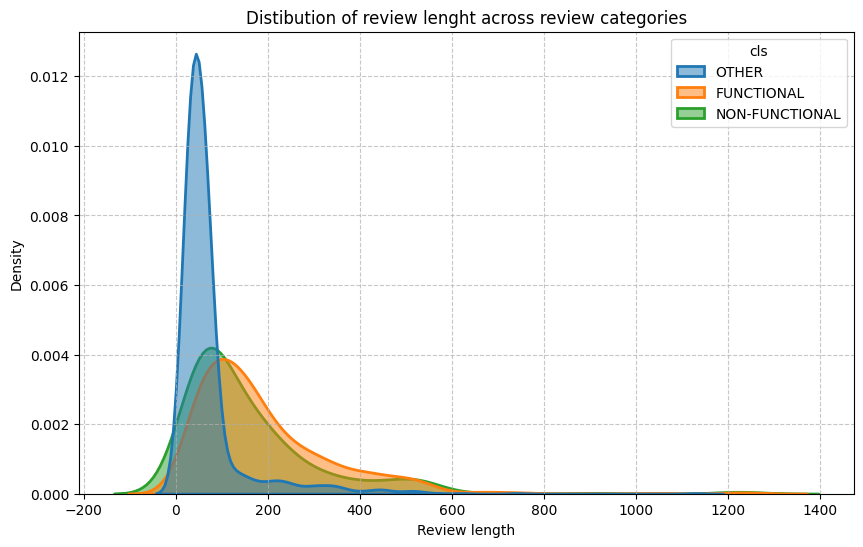

In [ ]:
plt.figure(figsize=(10, 6))

# sb.boxplot(data=data, x='cls', y='review_len', hue='cls', fill=True, saturation=0.75, width=0.55, gap=0.25, linewidth=2, legend=False)
# too many outliers, difficult to examine

sb.kdeplot(data=data,
           x='review_len',
           hue='cls',
           fill=True,
           common_norm=False, # Ensures that each density plot is normalized independently (integrates to 1), allowing for direct comparison of their shapes and relative densities.
           alpha=0.5,
           linewidth=2)

plt.title('Distibution of review lenght across review categories')
plt.xlabel('Review length')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Examine also review ratings

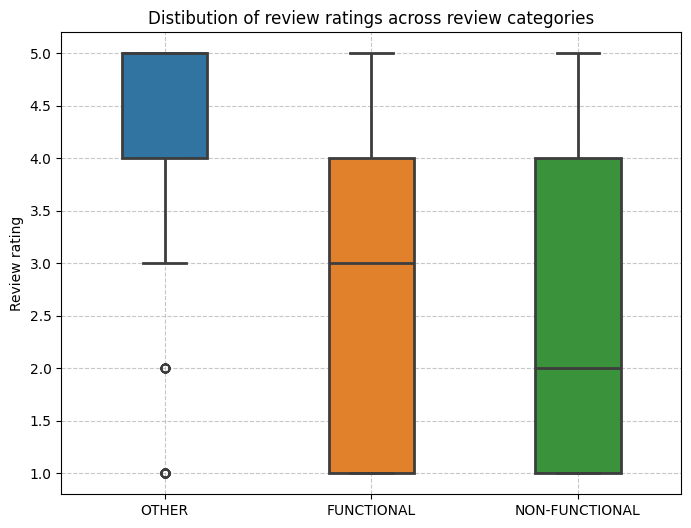

In [ ]:
plt.figure(figsize=(8, 6))

sb.boxplot(data=data, x='cls', y='rating', hue='cls', fill=True, saturation=0.75, width=0.55, gap=0.25, linewidth=2, legend=False)
# sb.kdeplot(data=data, x='rating', hue='cls', fill=True, common_norm=False, alpha=0.5, linewidth=2)

plt.title('Distibution of review ratings across review categories')
plt.ylabel('Review rating')
plt.xlabel('')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Both review length and rating seem to be relevant predictors of the outcome variable. So, we will keep these two variables in adddition to the review text and the outcome variables. The rest can be dropped

In [ ]:
data_sub = data[['rating', 'review_len', 'review', 'cls']]

In [ ]:
data_sub.head(10)

,rating,review_len,review,cls
0,5,40,cute!!!! the game is just to cute!!!! :3,OTHER
1,4,41,? well its ok but not bad nor is it great,OTHER
2,1,60,? have no idea how to feed dragon and boooorrr...,OTHER
3,2,295,when i play games it reboots about every third...,FUNCTIONAL
4,5,43,love my dragon have fun! yahoooey! godbless,OTHER
5,5,30,hope this is a good game!!!! ?,OTHER
6,1,56,sucks can't even play offline and everyone tak...,FUNCTIONAL
7,5,20,good that is so good,OTHER
8,5,20,? realy good and fun,OTHER
9,5,20,999 this is the best,OTHER


### Text preprocesing (using Spacy)

[`spaCy`](https://spacy.io/) is an open-source natural language processing library for Python. It is designed particularly for production use, and thus can be used to build applications that process massive volumes of text efficiently.

First, load spacy's basic English language model. This is, in fact, a pipeline of software componets for processing English language texts. A brief overview is given [here](https://spacy.io/usage/processing-pipelines) <br>

Note: In addition to English, spaCy supports several other languages. See [this page](https://spacy.io/usage/models) of the spacy's documentation to epxlore the available language models.

In [ ]:
nlp_pipe = spacy.load('en_core_web_sm')

Note: if the previous line ends in an error, it is because spacy's `en_core_web_sm` language model is not available. <br>To download it, execute the following line: <br>
`!python -m spacy download en` <br>
Note the use of `!` in front of the command to let the notebook know that it should be read as a command line command.

The Spacy's English pipeline that we have loaded (`en_core_web_sm`) consists of several text processing components including: *tok2vec*, *tagger*, *parser*, *lemmatizer*, and *ner*. For more information about this particular pipeline and the other available ones, see the [documentation](https://spacy.io/models/en).


#### Explore Spacy a bit

Let's explore what spacy provides us with using one randomly selected review

In [ ]:
sample_review = data_sub.sample(random_state=RAND_STATE)['review']
sample_review_cls = data_sub.sample(random_state=RAND_STATE)['cls']

In [ ]:
print(f"Review text:\n{sample_review.to_list()[0]}")
print(f"\nReview class:\n{sample_review_cls.to_list()[0]}")

Review text:
freezes all de way not @all on my samsung ace. i wasted my data for nothing

Review class:
FUNCTIONAL


Take the text of the sample review and pass it to spacy for processing

In [ ]:
sample_review = sample_review.iloc[0]

parsed_review = nlp_pipe(sample_review)

Examine individual tokens and their linguistic features (see the explanations and examples in the [spacy's documentation](https://spacy.io/usage/linguistic-features)).  

Let's explore a subset of the most frequently used these features:
* each POS (Part of Speech), representing the token's role in the sentence; a widely used POS tags can be seen [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
* lemma: the main (dictionary) word form

In [ ]:
token_text = [token.text for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]
token_lemma = [token.lemma_ for token in parsed_review]

pd.DataFrame(zip(token_text, token_pos, token_lemma), columns=['text', 'POS', 'lemma']).head(15)

,text,POS,lemma
0,freezes,VERB,freeze
1,all,PRON,all
2,de,X,de
3,way,ADV,way
4,not,PART,not
5,@all,PRON,@all
6,on,ADP,on
7,my,PRON,my
8,samsung,PROPN,samsung
9,ace,PROPN,ace


We can also visualise the results of the sentence parsing

In [ ]:
from spacy import displacy

displacy.render(parsed_review, style="dep", jupyter=True)

# an alternative, if more compact display is preferred
# displacy.render(parsed_review, style="dep", jupyter=True, options={'compact':True})


Examine stop words and remove them from the sample review

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# the total number of stop words:
print(f'Number of stop words: {len(spacy_stopwords)}\n')

# print first ten stop words:
print(f'First 50 stop words:\n{", ".join(sorted(list(spacy_stopwords))[:50])}')

Number of stop words: 326

First 50 stop words:
'd, 'll, 'm, 're, 's, 've, a, about, above, across, after, afterwards, again, against, all, almost, alone, along, already, also, although, always, am, among, amongst, amount, an, and, another, any, anyhow, anyone, anything, anyway, anywhere, are, around, as, at, back, be, became, because, become, becomes, becoming, been, before, beforehand, behind


Do the "cleaning" of the sample review by removing punctuation marks, spaces, stop words, and numbers

In [ ]:
filtered_tokens = [token.lemma_ for token in parsed_review
 if (not token.is_stop) and (not token.is_punct) and (not token.is_space) and (not token.like_num)]

print(f"Number of tokens before preprocessing: {len(parsed_review)}")
print(f"Number of tokens after preprocessing: {len(filtered_tokens)}")

Number of tokens before preprocessing: 17
Number of tokens after preprocessing: 8


In [ ]:
print(f"Sample review after pre-processing:\n{' '.join(filtered_tokens)}")

Sample review after pre-processing:
freeze de way @all samsung ace waste datum


#### Use spacy to preprocess all reviews

Now that we have seen what spacy can do for text preprocessing, let's now use spacy's functionalities to create a function for custom preprocessing of app reviews:  

In [ ]:
def spacy_preprocessing(doc):
    # Create tokens object with linguistic annotations
    tokens = nlp_pipe(doc)

    # remove punctuation, numbers, and URLs
    tokens = [token for token in tokens if ((not token.is_punct) and (not token.is_space) and (not token.like_num) and (not token.like_url))]

    # remove stopwords
    # tokens = [token for token in tokens if (not token.is_stop)]

    # Lemmatize each token and convert each token into lowercase
    words = [token.lemma_.lower() for token in tokens]

    # return preprocessed list of words
    return words

In [ ]:
sample_tokens = spacy_preprocessing(sample_review)
print(f"Sample review after preprocessing:\n{' '.join(sample_tokens)}\n")
print(f"Total number of words after preprocessing: {len(sample_tokens)}" )

Sample review after preprocessing:
freeze all de way not @all on my samsung ace i waste my datum for nothing

Total number of words after preprocessing: 16


#### Text cleaning

**Note**: to reduce the complexity of this task, we will skip the text cleaning component as it is not necessary for the text we are currently working with. Still, it is an often used component when working with text collected from the Web, and you are encouraged to explore it.

If (textual) data was collected from web sites, forums, online social networks, and other similar sources, it often needs to be "cleaned" before being sent to spaCy for preprocessing. This cleaning typically includes removal of HTML markup,links, hashtags and the like.

In [ ]:
def clean_text(text):
  text = re.sub(r"^http\S+", "", text) # remove links
  text = re.sub(r"^#(\S+)", "\\1", text) # remove # from hashtags
  text = re.sub(r"^@(\S+)", "", text) # remove any refeences to other users
  text = re.sub("<[^>]+>", "", text) # remove HTML mark-up (if any)
  text = text.strip().lstrip()
  return text

If you need a refresher on regular expressions, check a cheatsheet such as [this one](https://www.dataquest.io/cheat-sheet/regular-expressions-cheat-sheet/).

### Text transformation (using BoW)

Create counts-based vectoriser that will, for the given set of documents (reviews), build a Bag of Words (BoW) model. It can be easily created as an instance of the scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class

In [ ]:
def create_count_vectoriser(ngrams=(1,1), min_doc_freq=0.01, f_max=-1):
  vectoriser = CountVectorizer(
      tokenizer = spacy_preprocessing, # note the use of the above defined spacy_preprocessing f.
      ngram_range=ngrams,
      max_features=f_max if f_max > 0 else None,
      min_df=min_doc_freq
  )
  return vectoriser

### Create, fit, and test text classification pipeline

We will create a review classifier as a sequence ('pipeline') of several components, using the [sklearn's Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

**Pipeline** is an auxiliary sklearn's class that chains together multiple processing steps (called estimators or transformers) into a single, unified computational object. It can be considered as an assembly line for data:
* Raw data serves as the input
* It passes sequentially through a series of processing steps (e.g., cleaning, scaling, fine tuning).
* A trained classification / regression model comes out at the very end.

Why do we need / use it?
* Cleaner code, easier to read and maintain
* Prevention of data leakage, as the Pipeline ensures that the fit() and transoform() methods for every step in the processing sequence (e.g., a scaler, a classifier) are only called on the training data
* Seamless fine-tuning of hyper-parameters of the entire processing sequence (preprocessing + model).


To build a Pipeline, first, we split the data into train/test sets:

In [ ]:
X = data_sub[['review','review_len','rating']]
y = data_sub.cls.values

# do label encoding
y_encodings, y_levels = pd.factorize(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encodings, test_size = 0.2, random_state = RAND_STATE, stratify=y_encodings)

We will use the [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class to apply different data transformations to different columns in the dataset. This class is particularly useful when dealing with heterogeneous data, where some columns might be numerical and require scaling, while others are categorical and need encoding or textual and require special processing (as here).

In [ ]:
# Instantiate the vectoriser
count_vectorizer = create_count_vectoriser(ngrams=(1,2))

# Apply the vectoriser to the 'review' column and add the other two columns (rating and review length) as is
column_transformer = ColumnTransformer(
    [('word_counts', count_vectorizer, 'review')],
    remainder='passthrough',
    force_int_remainder_cols=False # added to avoid warnings about future version of the constructor
    )

**Note**: as stated somewhere above, we are skipping the text cleaning component and the transformer class defined below, but you are encouraged to explore the code related to the text claening component on your own and at your own pace as components such as this one are often necessary when working with textual data.

For the initial cleaning of the review text, we will create a custom transformer by subclassing scikit-learn's base class for all transformers ([`TransformerMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)). The reason for creating it as a transformer is to be able to include it in the sklearn Pipeline (only transformers and estimators can be included).<br> This will be the first step in text preprocessing (and the overall pipeline), which will be followed by the 'vectorisation' step.

In [ ]:
class TextCleaner(TransformerMixin):

    def transform(self, X):

        X['review'] = [clean_text(txt) for txt in X['review']]
        return X

    def fit(self, X, y=None):
        return self


As the classifier, we will use **Naive Bayes (NB)** classifier and specifically Multinomial NB (implemented in sklearn's [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) class).

It calculates the probability of a document belonging to a class based on the frequency of each term (feature) in that document.

This type of classifier has proven successful in text classification tasks; it is well-suited to handle the high-dimensional, sparse feature matrices that result from text vectorization. It also works well with (relatively) small datasets (as is our case).

In [ ]:
classifier = MultinomialNB()

We can now define the classification pipeline:

In [ ]:
pipe_1 = Pipeline([#('cleaner', TextCleaner()), # we are skipping this component to reduce the complexity of the task
                 ('vectorizer', column_transformer),
                 ('classifier', classifier)])

In [ ]:
# Fit the pipepline to the data from the training set
pipe_1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('word_counts',
                                                  CountVectorizer(min_df=0.01,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function spacy_preprocessing at 0x7f01d609e8e0>),
                                                  'review')])),
                ('classifier', MultinomialNB())])

Evaluate the model on the test data

First, examine the confusion matrix

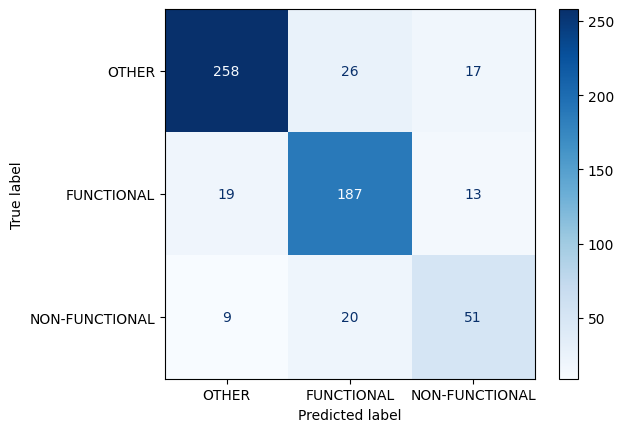

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        pipe_1,
        X_test,
        y_test,
        display_labels=y_levels,
        cmap='Blues',
    )

Now, we can compute evaluation measures:

Precision = TP/(TP + FP) <br>
Recall = TP/(TP + FN) <br>
Accuracy = (TP + TN) / N <br>
F1 = 2 x precision x recall/(precision + recall)

first, for each class individually and then average them across classes

In [ ]:
predictions_1 = pipe_1.predict(X_test)

report_1 = metrics.classification_report(y_true = y_test, y_pred = predictions_1)
print(report_1)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       301
           1       0.80      0.85      0.83       219
           2       0.63      0.64      0.63        80

    accuracy                           0.83       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.83      0.83      0.83       600



In [ ]:
y_levels

array(['OTHER', 'FUNCTIONAL', 'NON-FUNCTIONAL'], dtype=object)

Note:

*   `support` is the number of occurrences of each class in y_true
*   `macro avg` is the average of unweighted score per label (i.e. class)
*   `weighted avg` is the average of support-weighted score per label (i.e. class):

```
weighted avg for metric m = Σ m_i * (support_i/N), i=1..n_classes
```


You may want to take a look at [this](https://www.evidentlyai.com/classification-metrics/multi-class-metrics) or [this](https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/) article for an excellent explanation of how all these different metrics are computed and when they should be used.




Compute also [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html), since the dataset is imbalanced.

Note that balanced accuracy is, in fact, raw accuracy where each sample is weighted according to the inverse prevalence (see the "support" in the table above) of its true class.

In [ ]:
# balanced accuracy, adjusted for chance
print(f"Balanced accuracy: {metrics.balanced_accuracy_score(y_test, predictions_1, adjusted=True):0.4f}" )

Balanced accuracy: 0.6743


### Try to improve the classifer through hyper-parameters tuning

We will now try to improve the performance of the classifier by changing the way text transformation is done (Multinomial Naive Bayes does not give us space for hyper-parameter tuning). Some of the hyper-parameters often used for tuning include:
* `min_df` - minimum document freequency
* `ngram_range` - ngrams that will be used as features

We can try both, but that will take a long time to execute, so we'll focus on one and determine optimal value through *Cross-Validation*, using the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class.

Note: hyperparamter names have to be preceded by the name of the corresponding component (transformer or estimator) in the pipeline; in this case, the name of the relevant pipeline component is `vectorizer`. However, as this 'vectorizer' is not a single transformer but may contain multiple transformers (one per column), we need to specify the name of the particular transfomer we want to fine-tune - in this case, it is 'word_counts'. So, we have to precede the name of the hyperparamter with `vectorizer__word_counts__`.

In [ ]:
%%time

param_grid = dict(vectorizer__word_counts__min_df=[0.005, 0.01, 0.025])
grid_search = GridSearchCV(pipe_1, param_grid=param_grid, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time=  25.3s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time=  25.1s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time=  24.9s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time=  25.4s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time=  25.5s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time=  25.0s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time=  25.0s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time=  25.6s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time=  25.6s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time=  25.1s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time=  25.4s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 6min 41s, sys: 355 ms, total: 6min 41s
Wall time: 6min 44s


GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('word_counts',
                                                                         CountVectorizer(min_df=0.01,
                                                                                         ngram_range=(1,
                                                                                                      2),
                                                                                         tokenizer=<function spacy_preprocessing at 0x7f01d609e8e0>),
                                                                         'review')])),
                                       ('classifier', MultinomialNB())]),
             param_grid={'vectorizer__word_counts__min_df': [0.005, 0.01,
                                                             0.025]},
             verbose=2)

In [ ]:
print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'vectorizer__word_counts__min_df': 0.005}
best scrores:  0.85125


Re-run the pipeline with the optimal value for `min_df`:  

In [ ]:
best_mindf = grid_search.best_params_['vectorizer__word_counts__min_df']

# note how we configure the pipeline with a specific value for a hyperparameter
pipe_1.set_params(vectorizer__word_counts__min_df=best_mindf)
pipe_1.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('word_counts',
                                                  CountVectorizer(min_df=0.005,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function spacy_preprocessing at 0x7f01d609e8e0>),
                                                  'review')])),
                ('classifier', MultinomialNB())])

Make predictions with the fine-tuned pipeline and evaluate the performance

In [ ]:
predictions_2 = pipe_1.predict(X_test)

report_2 = metrics.classification_report(y_true=y_test, y_pred=predictions_2)
print(report_2)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       301
           1       0.78      0.86      0.82       219
           2       0.66      0.61      0.64        80

    accuracy                           0.83       600
   macro avg       0.79      0.78      0.78       600
weighted avg       0.83      0.83      0.83       600



In [ ]:
print(f"Balanced accuracy: {metrics.balanced_accuracy_score(y_test, predictions_2, adjusted=True):0.4f}" )

Balanced accuracy: 0.6697


### Try to improve the classifier with the Vector Space Model (TF-IDF vectoriser)

To try to improve the performance of the previous model, we will create TF-IDF vectoriser that, for the given set of documents (reviews), builds a vector space model with TF-IDF weights. This vectoriser will be an instance of the scikit-learn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class

In [ ]:
def create_tfidf_vectoriser(ngrams=(1,1), min_doc_freq=0.01):

    tfidf_vectorizer = TfidfVectorizer(
        tokenizer = spacy_preprocessing, # note the use of the above defined spacy_preprocessing f.
        ngram_range = ngrams,
        min_df = min_doc_freq,
        norm = "l2",
        use_idf = True,
        smooth_idf = True)

    return tfidf_vectorizer

Note: The hyper-parameters `norm`, `use_idf`, and `smooth_idf` used in the code above determine how weights (TF-IDF) are computed; to better understand them, see [Section 7.2.3.5 of the sklearn's User Guide](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).


As the classifier, we will again use MultinomialNB. While this classifier is theoretically best suited for integer feature counts (like raw word counts), in practice, it is the often best-performing Naive Bayes variant for TF-IDF features in text classification.

In [ ]:
# Instantiate Tf-Idf vectoriser
tf_idf_vectorizer = create_tfidf_vectoriser(ngrams=(1,2))

# Apply Tf-Idf vectoriser to the 'review' column and add the other two columns (rating and review length) as is
column_transformer = ColumnTransformer(
    [('tf_idf', tf_idf_vectorizer, 'review')],
    remainder='passthrough',
    force_int_remainder_cols=False)

# Define the classification pipeline
pipe_tfidf = Pipeline([#('cleaner', TextCleaner()),
                  ('vectorizer', column_transformer),
                  ('classifier', classifier)])

In [ ]:
# Fit the pipepline to the data from the training set
pipe_tfidf.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tf_idf',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function spacy_preprocessing at 0x7f01d609e8e0>),
                                                  'review')])),
                ('classifier', MultinomialNB())])

Evaluate the new model on the test data

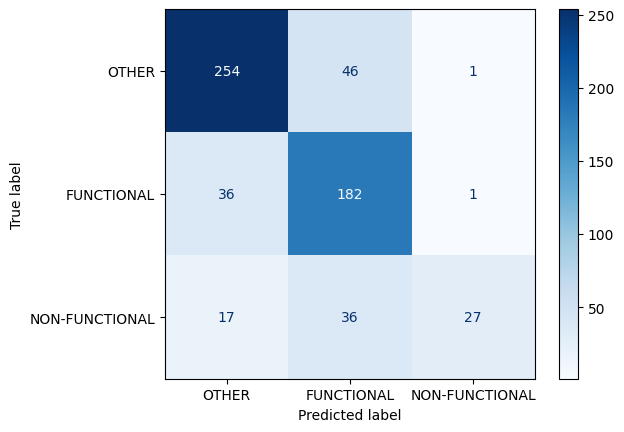

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_tfidf, X_test, y_test, display_labels=y_levels, cmap='Blues');

In [ ]:
pred_tfidf = pipe_tfidf.predict(X_test)

print(metrics.classification_report(y_true = y_test, y_pred = pred_tfidf))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       301
           1       0.69      0.83      0.75       219
           2       0.93      0.34      0.50        80

    accuracy                           0.77       600
   macro avg       0.82      0.67      0.69       600
weighted avg       0.79      0.77      0.76       600



In [ ]:
print(f"Balanced accuracy: {metrics.balanced_accuracy_score(y_test, pred_tfidf, adjusted=True):0.4f}" )

Balanced accuracy: 0.5062


### Try to improve the model by using another classifier

Complement Naive Bayes ([ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB)) is an adaptation of Multinomial Naive Bayes that is known to be more robust than MultinomialNB to imbalances in the training data.

The key to its suitability for imbalanced datasets lies in how it calculates feature probabilities: instead of calculating $P(\text{feature} | c)$, it calculates the probability of a feature given the *complement of the class*, which is the data from all other classes combined.

By focusing on the complement, CNB effectively uses a larger, more stable set of data (the combined data of all other classes) to estimate the influence of a feature on a given class.

The key intuition is if a feature is a strong indicator of a class $c$, it should be a weak indicator of the complement of that class.

From sklearn documentation: "The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks."

Since we have imbalanced dataset, CNB might prove useful.

In [ ]:
pipe_cnb = Pipeline([#('cleaner', TextCleaner()),
                 ('vectorizer', column_transformer),
                 ('classifier', ComplementNB())])

pipe_cnb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tf_idf',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function spacy_preprocessing at 0x7f01d609e8e0>),
                                                  'review')])),
                ('classifier', ComplementNB())])

Evaluate the model on the test data

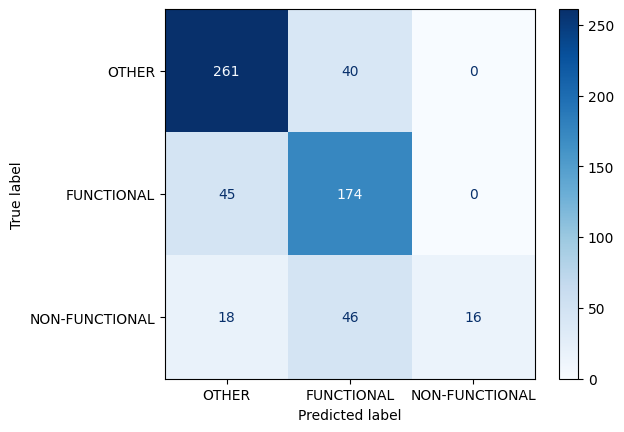

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_cnb, X_test, y_test, display_labels=y_levels, cmap='Blues');

In [ ]:
pred_cnb = pipe_cnb.predict(X_test)
print(metrics.classification_report(y_true = y_test, y_pred = pred_cnb))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       301
           1       0.67      0.79      0.73       219
           2       1.00      0.20      0.33        80

    accuracy                           0.75       600
   macro avg       0.82      0.62      0.63       600
weighted avg       0.78      0.75      0.73       600



In [ ]:
print(f"Balanced accuracy: {metrics.balanced_accuracy_score(y_test, pred_cnb, adjusted=True):0.4f}" )

Balanced accuracy: 0.4308


### Compare the created models

We will now compare the models we have built so far and will also include a dummy classifier to see how much better the models are compared to the most basic classifier (the one that generates predictions by respecting the training set’s class distribution)

In [ ]:
dummy_clf = DummyClassifier(strategy='stratified') # generates predictions by respecting the training set’s class distribution

dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
report_dummy = metrics.classification_report(y_true = y_test, y_pred = dummy_pred)
print(report_dummy)

              precision    recall  f1-score   support

           0       0.51      0.55      0.53       301
           1       0.36      0.35      0.36       219
           2       0.08      0.06      0.07        80

    accuracy                           0.41       600
   macro avg       0.32      0.32      0.32       600
weighted avg       0.40      0.41      0.40       600



The following function calculates macro and weighted average metrics and balanced accuracy based on the given input paramters for one classifier

In [ ]:
def get_model_metrics(y_true, y_pred, model_name):

    # compute P, R, F1 for both averages
    report = metrics.classification_report(y_true, y_pred, output_dict=True) # note that we are now requested the metrics in the form of a dicitionary

    # compute balanced accuracy
    b_acc = metrics.balanced_accuracy_score(y_true, y_pred)

    # extract metrics for the specified averages
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    results = {
        'Model': model_name,
        'Macro Precision': macro_avg['precision'],
        'Macro Recall': macro_avg['recall'],
        'Macro F1-Score': macro_avg['f1-score'],
        'Weighted Precision': weighted_avg['precision'],
        'Weighted Recall': weighted_avg['recall'],
        'Weighted F1-Score': weighted_avg['f1-score'],
        'Balanced Accuracy': b_acc
    }

    return results

In [ ]:
model_predictions = {
    'TF_MNB': predictions_1,
    'TF_FT_MNB': predictions_2,
    'TF-IDF_MNB': pred_tfidf,
    'TF-IDF_CNB': pred_cnb,
    'DUMMY': dummy_pred
}

all_results = list()

for model_name, model_pred in model_predictions.items():
  model_res = get_model_metrics(y_test, model_pred, model_name)
  all_results.append(model_res)

all_results_df = pd.DataFrame(all_results)
all_results_df.set_index("Model", inplace=True)
all_results_df = all_results_df.apply(lambda x: round(x, 4))

print("Model Performance Comparison:")
print(all_results_df)

Model Performance Comparison:
            Macro Precision  Macro Recall  Macro F1-Score  Weighted Precision  \
Model                                                                           
TF_MNB               0.7781        0.7828          0.7800              0.8294   
TF_FT_MNB            0.7862        0.7798          0.7817              0.8326   
TF-IDF_MNB           0.8159        0.6708          0.6949              0.7908   
TF-IDF_CNB           0.8249        0.6205          0.6317              0.7817   
DUMMY                0.3166        0.3203          0.3179              0.3984   

            Weighted Recall  Weighted F1-Score  Balanced Accuracy  
Model                                                              
TF_MNB               0.8267             0.8275             0.7828  
TF_FT_MNB            0.8300             0.8301             0.7798  
TF-IDF_MNB           0.7717             0.7603             0.6708  
TF-IDF_CNB           0.7517             0.7286             0.6